# Imports

This section imports all necessary libraries and modules, including PyTorch, NumPy, and a local module bayesipy.

In [ ]:
# Imports and setup for automatic reloading of modules
%load_ext autoreload
%autoreload 2

# Importing necessary libraries
import numpy as np
import torch
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
import copy

# Adjusting system path for local imports
sys.path.append("..")
sys.path.append(".")

# Importing custom modules from bayesipy
from bayesipy.utils.datasets import Synthetic_Dataset
from bayesipy.fmgp import FMGP
from bayesipy.laplace import Laplace
from bayesipy.mfvi import MFVI

# Experimental settings

To ensure reproducibility, a random seed is set. Then, a synthetic dataset is loaded and split into training and test sets, and data loaders are created to handle batched data processing.

In [2]:
# Setting reproducibility
from bayesipy.utils import assert_reproducibility

# Set seed to ensure consistent results across runs
assert_reproducibility(1234)

Load Dataset and desired split.

In [3]:
# Load synthetic dataset and split into train/test sets
dataset = Synthetic_Dataset()
train_dataset, test_dataset = dataset.get_splits()

Number of samples:  400
Input dimension:  (1,)
Label dimension:  1


Create Data loaders for training and test partitions.

In [4]:
# Define batch size and create DataLoaders for efficient data handling
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Pretrained MAP solution

In this section, a neural network is initialized and trained as a Maximum a Posteriori (MAP) solution. The network has two hidden layers with Tanh activations and is optimized using the Adam optimizer. After training, the best noise variance is selected by maximizing the log-likelihood on the training data.

In [5]:
# Initialize neural network for MAP solution with two hidden layers
f = torch.nn.Sequential(
    torch.nn.Linear(1, 50),
    torch.nn.Tanh(),
    torch.nn.Linear(50, 50),
    torch.nn.Tanh(),
    torch.nn.Linear(50, 1),
).to(torch.float64)  # Use double precision

# Set up optimizer and loss function
opt = torch.optim.Adam(f.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training loop for MAP optimization
start = timer()
iterator = iter(train_loader)
for _ in range(12000):
    try:
        X, y = next(iterator)  # Get batch data
    except StopIteration:
        iterator = iter(train_loader)
        X, y = next(iterator)

    opt.zero_grad()  # Clear gradients
    y_pred = f(X)  # Forward pass
    loss = criterion(y_pred, y)  # Calculate loss
    loss.backward()  # Backward pass
    opt.step()  # Update parameters
end = timer()

Create a copy of the pre-trained model for HamilTorch initialization

In [6]:
# Deep copy initial parameters for HMC sampling
params_init = copy.deepcopy(hamiltorch.util.flatten(f).detach())




This cell calculates the best noise variance by iterating over a range of noise values and computing the log-likelihood for each. The noise value that maximizes the log-likelihood is selected as the best noise variance.


In [7]:
# Find best noise variance by maximizing log-likelihood on training data
noises = np.linspace(0.001, 0.2, 100)
best_noise = 0
best_ll = -np.inf
mean = f(torch.tensor(train_dataset.inputs)).detach().cpu().numpy().flatten()
for noise in noises:
    # Gaussian density calculation
    ll = (
        -0.5 * np.log(2 * np.pi * noise)
        - 0.5 * np.square(train_dataset.targets.flatten() - mean) / noise
    ).sum()
    if ll > best_ll:
        best_ll = ll
        best_noise = noise

print("Best noise variance:", best_noise)
print("Best log-likelihood:", best_ll)

Best noise variance: 0.00301010101010101
Best log-likelihood: 545.231212359985


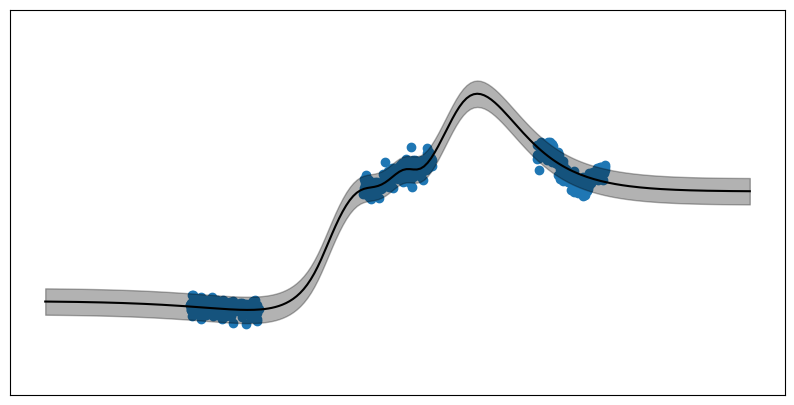

In [8]:
# Plot predictions with MAP uncertainty bounds
plt.figure(figsize=(10, 5))
plt.scatter(train_dataset.inputs, train_dataset.targets, label="Training points")
sort = np.argsort(test_dataset.inputs.flatten())

# Calculate predictions for test data
mean = f(torch.tensor(test_dataset.inputs)).detach().cpu().numpy().flatten()[sort]
plt.plot(test_dataset.inputs.flatten()[sort], mean, label="Predictions", color="black")
plt.fill_between(
    test_dataset.inputs.flatten()[sort],
    mean - 2 * np.sqrt(best_noise),
    mean + 2 * np.sqrt(best_noise),
    alpha=0.3,
    color="black",
)
plt.ylim(-1.2, 2)
plt.xticks([])
plt.yticks([])
plt.savefig("synthetic_regression_map.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Mean Field Variational Inference (MFVI)

This section uses MFVI. The MFVI class approximates the posterior distribution over the model parameters. The model is trained for 50,000 iterations, generating samples for predictions.

In [12]:
# Initialize Mean Field Variational Inference (MFVI) model
mfvi = MFVI(
    copy.deepcopy(f),  # Copy of pretrained model
    n_samples=200,  # Number of samples for predictions
    likelihood="regression",
    noise_std=4,  # Assumed noise standard deviation
    prior_precision=1.0,  # Prior precision for regularization
    y_mean=0.0,  # Mean of target for standardization
    y_std=1.0,  # Standard deviation of target
    seed=0,
)

# Train MFVI model with 50,000 iterations
losses = mfvi.fit(train_loader, 50000, verbose=True)

# Generate predictions for MFVI model on test dataset
mfvi_preds = mfvi.sample(torch.tensor(test_dataset.inputs)).detach().cpu().numpy()

Training : 100%|██████████| 50000/50000 [02:14<00:00, 372.86 iteration/s]


This plot compares MFVI predictions to the training data, showing mean predictions and uncertainty intervals derived from the MFVI posterior samples.

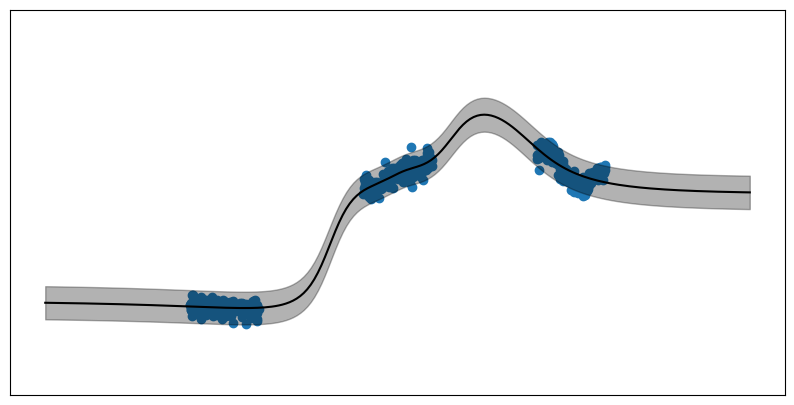

In [ ]:
# Plot MFVI predictions with uncertainty intervals
plt.figure(figsize=(10, 5))
plt.scatter(train_dataset.inputs, train_dataset.targets, label="Training points")
sort = np.argsort(test_dataset.inputs.flatten())

# Compute mean and variance from MFVI posterior samples
mean = mfvi_preds.mean(axis=0).flatten()
variance = mfvi.log_noise.exp().item() ** 2 + mfvi_preds.var(axis=0)
std = np.sqrt(variance).flatten()

plt.plot(
    test_dataset.inputs.flatten()[sort],
    mean,
    label="Predictions",
    color="black",
)
plt.fill_between(
    test_dataset.inputs.flatten()[sort],
    mean - 2 * std,
    mean + 2 * std,
    alpha=0.3,
    color="black",
)

plt.ylim(-1.2, 2)
plt.xticks([])
plt.yticks([])
plt.show()

# Fixed-Mean Gaussian Processes

In this section, Fixed-Mean Gaussian Processes with RBF kernel are used.


In [21]:
fmgp = FMGP(
    model=copy.deepcopy(f),  # Copy of MAP-trained model
    likelihood="regression",  # Regression setting
    kernel="RBF",  # RBF kernel for GP
    inducing_locations="kmeans",  # Use k-means to select inducing points
    num_inducing=10,  # Number of inducing points
    noise_variance=np.exp(-5),  # Initial noise variance
    subrogate_regularizer=True,  # Use subrogate regularizer
    y_mean=0,  # Mean of target
    y_std=1,  # Standard deviation of target
)

# Train FMGP model with specified learning rate and iterations
loss = fmgp.fit(iterations=70000, lr=0.001, train_loader=train_loader, verbose=True)

Initializing inducing locations... done
Creating Kernel Function... done


Training : 100%|██████████| 70000/70000 [04:57<00:00, 235.12 iteration/s, loss=-1126.35, lr=0.001]


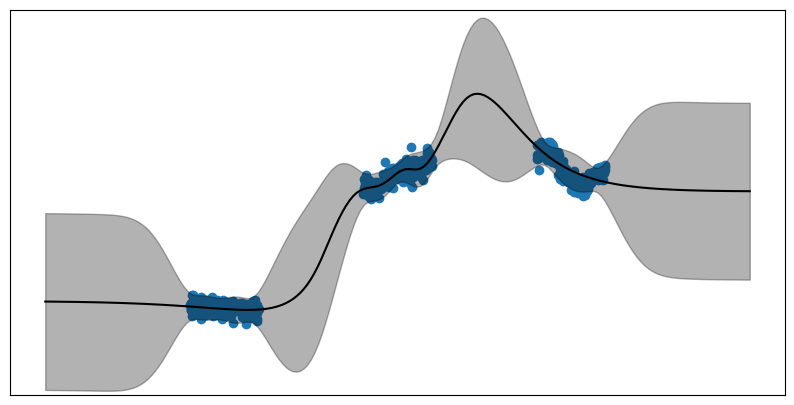

In [ ]:
# Plot FMGP predictions with uncertainty bounds
plt.figure(figsize=(10, 5))
plt.scatter(train_dataset.inputs, train_dataset.targets, label="Training points")
sort = np.argsort(test_dataset.inputs.flatten())

# Generate FMGP predictions and variances for test inputs
f_mean, f_var = fmgp.predict(torch.tensor(test_dataset.inputs))

# Plot FMGP mean predictions with 95% confidence intervals
plt.plot(
    test_dataset.inputs.flatten()[sort],
    f_mean.detach().cpu().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.fill_between(
    test_dataset.inputs.flatten()[sort],
    f_mean.detach().cpu().numpy().flatten()[sort]
    - 2 * np.sqrt(f_var.detach().cpu().numpy().flatten()[sort]),
    f_mean.detach().cpu().numpy().flatten()[sort]
    + 2 * np.sqrt(f_var.detach().cpu().numpy().flatten()[sort]),
    alpha=0.3,
    color="black",
)

plt.ylim(-1.2, 2)
plt.xticks([])
plt.yticks([])
plt.show()

# Laplace Approximation (LLA)

In this part, the Laplace approximation method is applied to approximate the posterior over the model parameters. This approach is computationally efficient and provides Gaussian approximations around a MAP solution.

In [23]:
# Initialize Laplace Approximation (LLA) model
lla = Laplace(
    model=copy.deepcopy(f),  # Copy of MAP-trained model
    likelihood="regression",  # Set for regression
    subset_of_weights="all",  # Use all weights for approximation
    hessian_structure="full",  # Full Hessian structure for Gaussian approximation
)

# Train LLA model to compute posterior scale
lla.fit(train_loader=train_loader)

# Define log prior and log noise for LLA hyperparameters
log_sigma = torch.zeros(1, requires_grad=True)
log_prior = torch.zeros(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

# Optimize LLA hyperparameters over 100 iterations
for i in range(100):
    hyper_optimizer.zero_grad()
    neg_marglik = -lla.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

# Print optimized prior precision and noise sigma
prior_precision = log_prior.exp().item()
sigma_noise = log_sigma.exp().item()
print("Prior precision:", prior_precision)
print("Sigma noise:", sigma_noise)

Prior precision: 0.199293851852417
Sigma noise: 0.06208699941635132


In [24]:
# Compute posterior scale for predictions and store as float64
lla._compute_scale()
lla._posterior_scale = lla._posterior_scale.to(torch.float64)

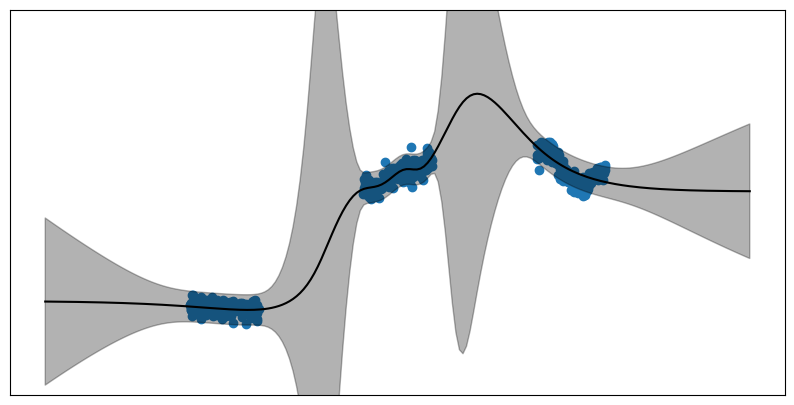

In [ ]:
# Plot LLA predictions with uncertainty intervals
plt.figure(figsize=(10, 5))
plt.scatter(train_dataset.inputs, train_dataset.targets, label="Training points")
sort = np.argsort(test_dataset.inputs.flatten())

# Generate mean and variance predictions with LLA
f_mean, f_var = lla.predict(torch.tensor(test_dataset.inputs))

# Plot LLA mean predictions with confidence intervals
plt.plot(
    test_dataset.inputs.flatten()[sort],
    f_mean.detach().cpu().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.fill_between(
    test_dataset.inputs.flatten()[sort],
    f_mean.detach().cpu().numpy().flatten()[sort]
    - 2 * np.sqrt(f_var.detach().cpu().numpy().flatten()[sort]),
    f_mean.detach().cpu().numpy().flatten()[sort]
    + 2 * np.sqrt(f_var.detach().cpu().numpy().flatten()[sort]),
    alpha=0.3,
    color="black",
)

plt.ylim(-1.2, 2)
plt.xticks([])
plt.yticks([])
plt.show()